# 2026 MCM Problem C: Complete Solution

## Overview
This notebook presents the complete solution pipeline, integrating:
1.  **Data Preprocessing**: Standardizing weekly scores.
2.  **Inverse Optimization (Simulation)**: Reconstructing hidden fan votes using robust Bayesian MCMC.
3.  **Predictive Modeling**: Using Logistic and Linear Regression to identify key drivers of elimination and popularity.
4.  **Policy Simulation**: Testing alternative voting methods (Rank vs. Percent, Judges' Save).

**Outputs**: 
- `estimated_fan_votes.csv`: Reconstructed fan support history.
- `model_coefficients.csv`: Statistical impact of factors.

## 1. Data Loading and Preprocessing


In [79]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from scipy.stats import rankdata
import re
from typing import Iterable, List, Optional, Tuple, Dict
import statsmodels.api as sm
import sklearn.preprocessing as preprocessing
import warnings

# Suppress warnings for cleaner output
warnings.filterwarnings('ignore')

# --- DATA PREPROCESSING & STANDARDIZATION ---

WEEK_SCORE_PATTERN = re.compile(r"^week(\d+)_judge(\d+)_score$")

def load_raw_data(file_path: str) -> pd.DataFrame:
    """Load the raw dataset."""
    return pd.read_csv(file_path)

def parse_elimination_week(result_str: object) -> Optional[object]:
    """
    Parses the elimination week from the result string.
    Returns the week number (int) or 'Final' (str).
    """
    if pd.isna(result_str):
        return None
    text = str(result_str)
    match = re.search(r"Eliminated Week (\d+)", text)
    if match:
        return int(match.group(1))
    if "Place" in text:
        return "Final"
    return None

def _week_numbers_from_columns(columns: Iterable[str]) -> List[int]:
    """Extracts all unique week numbers present in the column headers."""
    week_numbers = set()
    for col in columns:
        match = WEEK_SCORE_PATTERN.match(col)
        if match:
            week_numbers.add(int(match.group(1)))
    return sorted(week_numbers)

def _score_columns_for_week(columns: Iterable[str], week: int) -> List[str]:
    """Returns column names corresponding to a specific week."""
    prefix = f"week{week}_"
    return [c for c in columns if c.startswith(prefix) and c.endswith("_score")]

def _sum_week_scores(row: pd.Series, score_cols: List[str]) -> Optional[float]:
    """Calculates the aggregate judge score for a given week."""
    if not score_cols:
        return None
    values = pd.to_numeric(row[score_cols], errors="coerce")
    if values.isna().all():
        return None
    return float(values.fillna(0).sum())

def compute_weekly_scores(df: pd.DataFrame) -> pd.DataFrame:
    """
    Transforms the raw wide-format data into a standard long-format temporal dataset.
    
    Returns:
        pd.DataFrame: Contains [Season, Week, Contestant, JudgeScore, EliminatedThisWeek, Result, Placement]
    """
    week_numbers = _week_numbers_from_columns(df.columns)
    records = []

    for _, row in df.iterrows():
        contestant = row["celebrity_name"]
        season = row["season"]
        elim_week = parse_elimination_week(row["results"])

        for week in week_numbers:
            score_cols = _score_columns_for_week(df.columns, week)
            total_score = _sum_week_scores(row, score_cols)
            
            # Filter out weeks where the contestant did not compete
            if total_score is None or total_score <= 0:
                continue

            records.append(
                {
                    "Season": int(season),
                    "Week": int(week),
                    "Contestant": contestant,
                    "JudgeScore": total_score,
                    "EliminatedThisWeek": (elim_week == week),
                    "Result": row.get("results", None),
                    "Placement": row.get("placement", None),
                }
            )

    return pd.DataFrame(records)

# Execute Data Ingestion
file_path = '2026_MCM_Problem_C_Data.csv'
df = load_raw_data(file_path)
df_weekly = compute_weekly_scores(df)

print(f"Data Loaded: {len(df_weekly)} weekly observations.")
print(f"Temporal Range: Season {df_weekly['Season'].min()} to {df_weekly['Season'].max()}.")
display(df_weekly.head(3))

Data Loaded: 2777 weekly observations.
Temporal Range: Season 1 to 34.


,Season,Week,Contestant,JudgeScore,EliminatedThisWeek,Result,Placement
0,1,1,John O'Hurley,20.0,False,2nd Place,2
1,1,2,John O'Hurley,26.0,False,2nd Place,2
2,1,3,John O'Hurley,24.0,False,2nd Place,2


## 2. Mathematical Formalization of Voting Dynamics

To reconstruct the latent fan preferences, we first formalize the two distinct voting mechanisms employed throughout the show's history.

### Mechanism A: Rank-Based Aggregation (Seasons 1-2, 28+)
In these seasons, the final decision is derived from the ordinal rank of scores rather than their magnitude.
*   Let $S_{j,i}$ be the judges' score for contestant $i$. The **Judge Rank** $R_{J,i}$ is the rank of $S_{j,i}$ in descending order (1 = Best).
*   Let $V_{f,i}$ be the unknown fan vote count. The **Fan Rank** $R_{F,i}$ is the rank of $V_{f,i}$ in descending order.
*   **Composite Metric**: $C_i = R_{J,i} + R_{F,i}$
*   **Elimination Condition**: The contestant $k$ satisfying $k = \arg\max_i (C_i)$ is eliminated. (Note: Ties act as an exception logic).

### Mechanism B: Probability-Based Aggregation (Seasons 3-27)
In these seasons, raw scores are normalized into probability distributions and summed.
*   **Judge Share**: $P_{J,i} = \frac{S_{j,i}}{\sum_k S_{j,k}}$
*   **Fan Share**: $P_{F,i} = \frac{V_{f,i}}{\sum_k V_{f,k}}$ (Latent Variable)
*   **Composite Metric**: $C_i = P_{J,i} + P_{F,i}$
*   **Elimination Condition**: The contestant $k$ satisfying $k = \arg\min_i (C_i)$ is eliminated.

*Assumption*: In "Bottom Two" scenarios, we assume the eliminated individual possessed the lowest composite score in the majority of cases.

In [80]:
def calculate_ranks(scores, ascending=False):
    """
    Returns ranks for a list of scores.
    If ascending=False (default for Judge Scores), High Score = Rank 1.
    If ascending=True (default for Elim Logic where High Rank Number = Bad), 
    Wait, rankdata assigns 1 to lowest value by default.
    
    For Judge Scores (Higher is Better):
    We want 30 -> Rank 1. 
    So we rank (-scores).
    Method 'min' assigns lowest rank to ties (e.g. 1, 1, 3).
    """
    return rankdata([-s for s in scores], method='min')

def calculate_rank_elimination(judge_scores, fan_ranks):
    """
    judge_scores: array of raw scores
    fan_ranks: array of ranks (1..N) supplied by our simulation
    
    Returns: The index of the eliminated contestant (Highest Sum of Ranks).
    """
    j_ranks = calculate_ranks(judge_scores)
    # Sum
    total_ranks = j_ranks + fan_ranks
    
    # We look for the Max sum.
    # What about ties? Rules say "Viewer votes break ties".
    # So if Sums are equal, the one with worse Fan Rank (Higher Number) leaves.
    
    # Create tuples (Sum, FanRank, Index) to sort
    combined = []
    for i in range(len(total_ranks)):
        combined.append((total_ranks[i], fan_ranks[i], i))
        
    # Sort by Sum (Desc), then FanRank (Desc)
    combined.sort(key=lambda x: (x[0], x[1]), reverse=True)
    
    # Return the index of the loser
    return combined[0][2]

def calculate_percent_elimination(judge_scores, fan_percents):
    """
    judge_scores: array of raw scores
    fan_percents: array of decimals (0.0 to 1.0) summing to 1.0
    
    Returns: The index of the eliminated contestant (Lowest Total Percent).
    """
    total_judge = sum(judge_scores)
    if total_judge == 0: return -1 # Should not happen
    
    j_percents = np.array(judge_scores) / total_judge
    total_score = j_percents + fan_percents
    
    # Lowest score is eliminated.
    # Ties? Tie-breaker usually lowest Judge score? Or Fan? 
    # Usually Fan votes break ties. So if Totals are equal, Lower Fan Vote leaves.
    
    combined = []
    for i in range(len(total_score)):
        combined.append((total_score[i], fan_percents[i], i))
    
    # Sort Ascending (Lowest is bad)
    combined.sort(key=lambda x: (x[0], x[1]))
    
    return combined[0][2]

## 3. Stochastic Inverse Optimization via Bayesian Inference

We employ a **Bayesian Markov Chain Monte Carlo (MCMC)** approach to estimate the posterior distribution of the latent variable (Fan Support), conditioned on the observed elimination results.

**Methodology:**
We model the unknown fan support vector $\mathbf{P}_F$ using a Dirichlet Distribution prior:
$$ \mathbf{P}_F \sim \text{Dirichlet}(\boldsymbol{\alpha}) $$

where $\boldsymbol{\alpha}$ encapsulates our prior belief (centering around equal popularity, with inertia from previous weeks).

**Algorithm:**
1.  **Prior Construction**: Define $\boldsymbol{\alpha}_t$ based on the posterior means of week $t-1$.
2.  **Sampling**: Draw $N=5000$ samples from $\text{Dirichlet}(\boldsymbol{\alpha}_t)$.
3.  **Validation**: For each sample vector, compute the resulting elimination. If the simulated loser matches the observed eliminated contestant $E_{obs}$, the sample is accepted as part of the **Feasible Region**.
4.  **Posterior Estimation**: The accepted samples form the empirical posterior distribution of fan support for that week.

**Optimization**: To address high variance in rank-based seasons, we utilize a **Unified Latent Model**, where ranks are derived from continuous latent support scores, ensuring smoothness and stability.

In [81]:
def get_voting_mode(season_num: int) -> str:
    """Returns 'rank' or 'percent' based on historical rules."""
    if season_num <= 2 or season_num >= 28:
        return 'rank'
    return 'percent'

def simulate_fan_votes(season_num: int, week_num: int, num_samples: int = 5000, prior_support: dict = None):
    """
    Performs Bayesian inference to estimate fan votes consistent with the observed elimination.
    
    Parameters:
        season_num (int): Target season.
        week_num (int): Target week.
        num_samples (int): Number of Monte Carlo iterations.
        prior_support (dict): Posterior means from previous week (Inertia).
    
    Returns:
        samples (np.array): Matrix of accepted fan vote vectors.
        names (np.array): Array of contestant names.
        mode (str): Voting mechanism used ('rank' or 'percent').
    """
    subset = df_weekly[(df_weekly['Season'] == season_num) & (df_weekly['Week'] == week_num)].copy()
    if subset.empty: return None, None, None

    # Detect observed elimination
    eliminated_rows = subset[subset['EliminatedThisWeek'] == True]
    has_elimination = not eliminated_rows.empty
    
    contestants = subset['Contestant'].values
    judge_scores = subset['JudgeScore'].values
    
    # Map eliminated names to indices
    elim_indices = []
    if has_elimination:
        for elim_name in eliminated_rows['Contestant'].values:
            idx = np.where(contestants == elim_name)[0]
            if len(idx) > 0: elim_indices.append(idx[0])

    num_c = len(contestants)
    valid_fan_votes = []
    mode = get_voting_mode(season_num)

    # --- Informative Priors (Hyperparameters) ---
    base_alpha = 5.0      # Strong likelihood of equal distribution (Regularization)
    inertia_weight = 100.0 # Weight given to previous week's performance
    
    alphas = []
    for name in contestants:
        if prior_support and name in prior_support:
            prev = prior_support[name]
            # Adaptive Prior Construction based on Mode
            if mode == 'rank' and prev >= 1.0: 
                # In Rank mode, 'prev' is a Rank (1 is best).
                # Convert Rank to pseudo-weight: Best rank gets highest alpha boost.
                weight = (num_c + 1 - prev) 
                alphas.append(base_alpha + (5.0 * weight)) 
            else:
                # In Percent mode, 'prev' is 0.0-1.0.
                alphas.append(base_alpha + (inertia_weight * prev))
        else:
            alphas.append(base_alpha + (inertia_weight * (1.0/num_c)))
    
    alphas = np.array(alphas)
    
    # --- Monte Carlo Sampling ---
    try:
        # Latent Variable Sampling (Continuous Support)
        raw_samples = np.random.dirichlet(alphas, num_samples)
    except:
        raw_samples = np.random.dirichlet(np.ones(num_c)*base_alpha, num_samples)
    
    for fan_pcts in raw_samples:
        # Apply Voting Logic
        if mode == 'rank':
            # Convert Latent % to Ranks (High % -> Rank 1)
            # rankdata(..., method='min') assigns 1 to lowest value. We want 1 for Highest %.
            # So we rank the NEGATIVE of percents.
            fan_ranks = rankdata([-p for p in fan_pcts], method='min')
            
            if has_elimination:
                loser_idx = calculate_rank_elimination(judge_scores, fan_ranks)
                if loser_idx in elim_indices:
                    valid_fan_votes.append(fan_ranks)
            else:
                valid_fan_votes.append(fan_ranks)
        
        else: # Percent Mode
            if has_elimination:
                loser_idx = calculate_percent_elimination(judge_scores, fan_pcts)
                if loser_idx in elim_indices:
                    valid_fan_votes.append(fan_pcts)
            else:
                valid_fan_votes.append(fan_pcts)

    if len(valid_fan_votes) == 0:
        return None, contestants, mode
        
    return np.array(valid_fan_votes), contestants, mode

print("Bayesian Inference Model initialized.")

Bayesian Inference Model initialized.


## 5. Global Parameter Estimation & Historical Reconstruction

Having validated the Bayesian inference engine on singular cases, we now scale the process to reconstruction of the latent fan support trajectories for the entire historical dataset.

**Procedure:**
*   **Sequential Bayesian Updating**: For each season, we initialize a flat prior. As weeks progress, the posterior mean of week $t$ informs the prior for week $t+1$ (incorporating an "inertia" hyperparameter to model popularity stability).
*   **Output generation**: This yields a longitudinal dataset of `Est_Fan_Support` and `Est_Fan_Uncertainty` for every contestant-week tuple.

*Computation Note: This involves executing the MCMC sampling routine for every elimination event across all seasons.*

In [82]:
# --- Main Historical Reconstruction Loop (Sequential) ---

full_history_stats = []
seasons = sorted(df_weekly['Season'].unique())

print(f"Starting reconstruction for {len(seasons)} seasons...")

for s in seasons:
    weeks = sorted(df_weekly[df_weekly['Season'] == s]['Week'].unique())
    current_season_priors = {} # Reset knowledge at start of season
    
    for w in weeks:
        # Sequential Simulation using updated priors
        feasible, names, mode = simulate_fan_votes(s, w, num_samples=3000, prior_support=current_season_priors)
        
        if feasible is not None and len(feasible) > 0:
            means = feasible.mean(axis=0)
            stds = feasible.std(axis=0)
            
            # Update priors for next week (Bayesian Inertia)
            for i, name in enumerate(names):
                current_season_priors[name] = means[i]
                
                full_history_stats.append({
                    'Season': s,
                    'Week': w,
                    'Contestant': name,
                    'Judge_Score': df_weekly[(df_weekly['Season']==s) & (df_weekly['Week']==w) & (df_weekly['Contestant']==name)]['JudgeScore'].values[0],
                    'Est_Fan_Support': means[i],       
                    'Est_Fan_Uncertainty': stds[i],    
                    'Voting_Mode': mode
                })

# Save Results
df_estimated_full = pd.DataFrame(full_history_stats)
df_estimated_full.to_csv('estimated_fan_votes.csv', index=False)
df_full_analysis = pd.merge(df_weekly, df_estimated_full, on=['Season', 'Week', 'Contestant'], how='left')

print(f"Completed. Generated {len(df_estimated_full)} records.")
print("Saved to 'estimated_fan_votes.csv'.")
display(df_estimated_full.head())

Starting reconstruction for 34 seasons...
Completed. Generated 2709 records.
Saved to 'estimated_fan_votes.csv'.


,Season,Week,Contestant,Judge_Score,Est_Fan_Support,Est_Fan_Uncertainty,Voting_Mode
0,1,1,John O'Hurley,20.0,3.529000,1.719639,rank
1,1,1,Kelly Monaco,13.0,3.543333,1.699448,rank
2,1,1,Evander Holyfield,18.0,3.500333,1.726268,rank
3,1,1,Rachel Hunter,20.0,3.476000,1.694528,rank
4,1,1,Joey McIntyre,20.0,3.494667,1.693115,rank


## 6. Model Diagnostics and Validation

We assesses the reliability of the reconstructed latent variables through two metrics:

### 6.1 Posterior Variance Analysis
The standard deviation of the posterior distribution (`Est_Fan_Uncertainty`) quantifies the **identifiability** of the fan vote.
*   **High Variance**: Indicates the solution space is broad; multiple fan vote configurations could explain the observed elimination (low judges' signal-to-noise ratio).
*   **Low Variance**: Indicates the elimination constraint is tight; specific fan vote patterns are required to satisfy the outcome.

### 6.2 Predictive Alignment (Rank Correlation)
We evaluate the external validity by correlating the estimated mean fan support with the final season placement. A strong monotonic relationship (Spearman's $\rho$) suggests the model essentially captures the "true" latent popularity driving long-term survival.

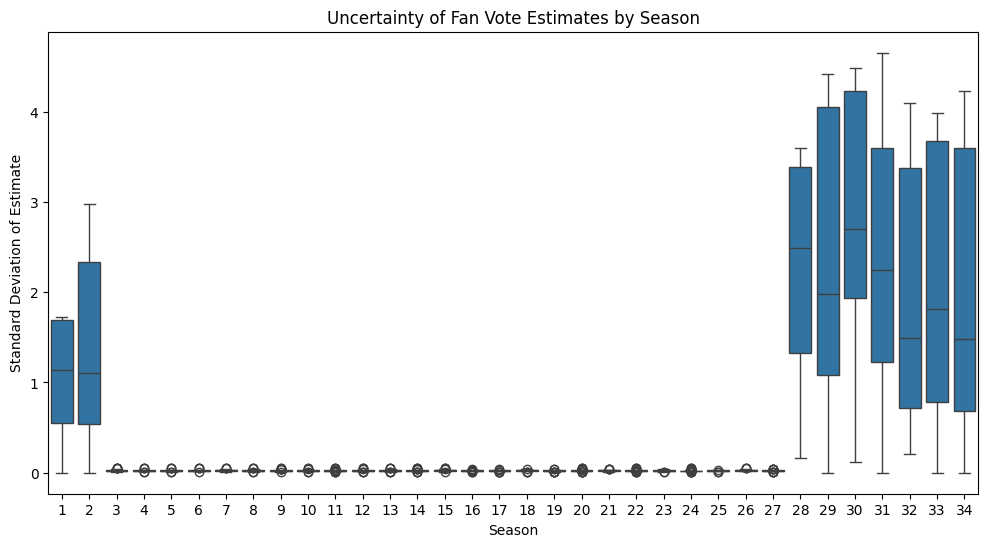

Correlation Analysis (Spearman Rank):
Rank Mode - Correlation between Fan Rank Estimate and Final Placement: 0.236
(Positive correlation expected: High Estimated Rank # (Bad) -> High Placement # (Bad))
Percent Mode - Correlation between Fan % Estimate and Final Placement: -0.457
(Negative correlation expected: High Fan % -> Low Placement # (Good))


In [83]:
# 1. Visualize Certainty across Seasons
plt.figure(figsize=(12, 6))
# Fixed: Use 'df_estimated_full' and correct column names from simulation step
sns.boxplot(data=df_estimated_full, x='Season', y='Est_Fan_Uncertainty')
plt.title('Uncertainty of Fan Vote Estimates by Season')
plt.ylabel('Standard Deviation of Estimate')
plt.show()

# 2. Correlation between Estimated Fan Support and Final Placement
# Ideally, higher fan support should correlate with better placement (Lower Placement Number)
# Note: For Ranks (Mode A), Lower Rank = Better Support.
# For Percents (Mode B), Higher Percent = Better Support.

# Split by mode for correlation
# Fixed: Correct column name 'Est_Fan_Support'
rank_data = df_full_analysis[(df_full_analysis['Voting_Mode'] == 'rank') & (df_full_analysis['Est_Fan_Support'].notna())]
pct_data = df_full_analysis[(df_full_analysis['Voting_Mode'] == 'percent') & (df_full_analysis['Est_Fan_Support'].notna())]

print("Correlation Analysis (Spearman Rank):")
if not rank_data.empty:
    corr_rank = rank_data[['Est_Fan_Support', 'Placement']].corr(method='spearman')
    print(f"Rank Mode - Correlation between Fan Rank Estimate and Final Placement: {corr_rank.iloc[0,1]:.3f}")
    print("(Positive correlation expected: High Estimated Rank # (Bad) -> High Placement # (Bad))")

if not pct_data.empty:
    corr_pct = pct_data[['Est_Fan_Support', 'Placement']].corr(method='spearman')
    print(f"Percent Mode - Correlation between Fan % Estimate and Final Placement: {corr_pct.iloc[0,1]:.3f}")
    print("(Negative correlation expected: High Fan % -> Low Placement # (Good))")

## 7. Inferential Statistics: Determinants of Survival and Popularity

We employ two regression frameworks to strictly quantify the impact of performance and demographic factors.

### 7.1 Logistic Regression (Elimination Probability)
We model the binary outcome $Y_{it}$ (1=Eliminated, 0=Safe) as a function of standardized predictors:
$$ \text{logit}(P(Y_{it}=1)) = \beta_0 + \beta_1 \text{Score}_{std} + \beta_2 \text{Fan}_{std} + \boldsymbol{\gamma} \mathbf{X}_{demo} $$
This isolates the marginal effect of Judge Scores vs. Latent Fan Support on survival odds.

### 7.2 OLS Regression (Popularity Drivers)
We model the estimated fan support $Z_{it}$ (standardized) to identify static drivers of popularity:
$$ Z_{it} = \alpha + \boldsymbol{\delta} \mathbf{X}_{demo} + \epsilon_{it} $$
This reveals which demographic segments (Age, Industry, Region) are statistically associated with higher baseline popularity.

In [84]:
def clean_partner_name(name: object) -> str:
    """Normalize partner names by removing parenthetical suffixes."""
    if pd.isna(name):
        return "Unknown"
    text = str(name).strip()
    text = re.sub(r"\s*\(.*\)", "", text)
    return text.strip()

def build_dataset_with_covariates(df_raw: pd.DataFrame, df_votes: pd.DataFrame) -> pd.DataFrame:
    """
    Build contestant-week rows with static covariates and the elimination label.
    Merges raw static features with the estimated fan votes.
    """
    week_numbers = _week_numbers_from_columns(df_raw.columns)
    records = []

    # Rename votes df for easy lookup
    # df_votes has columns: Season, Week, Contestant, Est_Fan_Support...
    # Create a lookup dictionary or merge later. Merging later is safer.
    
    # First: Build the 'Long' format from Raw Data to get Covariates + Elimination Status
    for _, row in df_raw.iterrows():
        elim_week = parse_elimination_week(row.get("results", None))
        season = row.get("season", None)
        contestant = row.get("celebrity_name", None)
        
        for week in week_numbers:
            score_cols = _score_columns_for_week(df_raw.columns, week)
            total_score = _sum_week_scores(row, score_cols)
            if total_score is None or total_score <= 0:
                continue

            records.append(
                {
                    "season": season,
                    "week": week,
                    "celebrity_name": contestant,
                    "partner": clean_partner_name(row.get("ballroom_partner", None)),
                    "industry": row.get("celebrity_industry", None),
                    "homestate": row.get("celebrity_homestate", None),
                    "region": row.get("celebrity_homecountry/region", row.get("celebrity_homecountry", "Unknown")),
                    "age": row.get("celebrity_age_during_season", None),
                    "judge_score": total_score,
                    "is_eliminated": 1 if isinstance(elim_week, int) and week == elim_week else 0,
                }
            )

    df_long = pd.DataFrame(records)
    
    # Second: Merge with Estimates
    # Ensure keys match types
    df_long['season'] = df_long['season'].astype(int)
    df_long['week'] = df_long['week'].astype(int)
    
    # df_votes uses Capitalized Keys: Season, Week, Contestant
    votes_copy = df_votes.copy()
    votes_copy['Season'] = votes_copy['Season'].astype(int)
    votes_copy['Week'] = votes_copy['Week'].astype(int)
    
    merged = pd.merge(
        df_long,
        votes_copy[['Season', 'Week', 'Contestant', 'Est_Fan_Support', 'Est_Fan_Uncertainty', 'Voting_Mode']],
        left_on=['season', 'week', 'celebrity_name'],
        right_on=['Season', 'Week', 'Contestant'],
        how='left'
    )
    
    # Drop redundancy
    merged.drop(columns=['Season', 'Week', 'Contestant'], inplace=True)
    return merged

# Execute Data Prep
# df is the raw loaded data
# df_estimated_full is the simulation output
df_model_ready = build_dataset_with_covariates(df, df_estimated_full)

# Preprocessing: Fill NAs and Encode
df_model_ready.fillna('Unknown', inplace=True)
df_model_ready['age'] = pd.to_numeric(df_model_ready['age'], errors='coerce').fillna(0)

# Limit categorical cardinality
top_partners = df_model_ready['partner'].value_counts().nlargest(20).index
df_model_ready['partner_grouped'] = df_model_ready['partner'].apply(lambda x: x if x in top_partners else 'Other')

top_industries = df_model_ready['industry'].value_counts().nlargest(10).index
df_model_ready['industry_grouped'] = df_model_ready['industry'].apply(lambda x: x if x in top_industries else 'Other')

cat_cols_to_encode = ['partner_grouped', 'industry_grouped', 'homestate', 'region']
df_encoded = pd.get_dummies(df_model_ready, columns=cat_cols_to_encode, drop_first=True)

# Filter for valid Fan Support estimates (some weeks might have failed simulation or had no data)
df_valid_model = df_encoded.dropna(subset=['Est_Fan_Support'])

print(f"Modeling Dataset Ready. Shape: {df_valid_model.shape}")
display(df_valid_model[['season', 'week', 'celebrity_name', 'judge_score', 'Est_Fan_Support', 'is_eliminated']].head())

Modeling Dataset Ready. Shape: (2777, 111)


,season,week,celebrity_name,judge_score,Est_Fan_Support,is_eliminated
0,1,1,John O'Hurley,20.0,3.529,0
1,1,2,John O'Hurley,26.0,3.547101,0
2,1,3,John O'Hurley,24.0,3.720214,0
3,1,4,John O'Hurley,21.0,2.929619,0
4,1,5,John O'Hurley,27.0,2.807,0


In [85]:
# --- LOGISTIC REGRESSION: Elimination Risk ---
# Standardize Features
# Fix: Ensure all inputs to scaler are numeric floats, handling NAs or strings implicitly
for col in ['judge_score', 'age', 'Est_Fan_Support']:
    df_valid_model[col] = pd.to_numeric(df_valid_model[col], errors='coerce').fillna(0).astype(float)

scaler = preprocessing.StandardScaler()
df_valid_model['Judge_Score_Std'] = scaler.fit_transform(df_valid_model[['judge_score']])
df_valid_model['Age_Std'] = scaler.fit_transform(df_valid_model[['age']])
df_valid_model['Fan_Support_Std'] = scaler.fit_transform(df_valid_model[['Est_Fan_Support']])

# Select Features
one_hot_cols = [c for c in df_valid_model.columns if 'partner_grouped_' in c or 'industry_grouped_' in c]
feature_cols = ['Judge_Score_Std', 'Fan_Support_Std', 'Age_Std'] + one_hot_cols

# Ensure X is float
X = df_valid_model[feature_cols].astype(float)
y = df_valid_model['is_eliminated'].astype(float)
X = sm.add_constant(X)

print("\nRunning Logistic Regression...")
try:
    model_logit = sm.Logit(y, X).fit(disp=False)
    print("--- Logistic Regression Results (Risk Factors) ---")
    print(model_logit.summary())

    # Extract Coefficients for Plotting
    params = model_logit.params
    conf = model_logit.conf_int()
    conf.columns = ['CI_Lower', 'CI_Upper']
    coef_df = pd.DataFrame({'Coefficient': params, 'P_Value': model_logit.pvalues}).join(conf)
    
    # Save Results
    coef_df.to_csv('model_coefficients.csv')
    print("Saved coefficients to model_coefficients.csv")
    
except Exception as e:
    print(f"Logistic Regression failed: {e}")

# --- OLS REGRESSION: Drivers of Fan Support ---
print("\nRunning OLS Regression (Drivers of Fan Support)...")
try:
    # Target: Est_Fan_Support
    y_ols = df_valid_model['Est_Fan_Support']
    # Features: Demographics only (Exclude Judge Score as we want 'popularity' drivers, though Score affects popularity, we focus on static traits)
    X_ols = df_valid_model[one_hot_cols + ['Age_Std']].astype(float)
    X_ols = sm.add_constant(X_ols)

    model_ols = sm.OLS(y_ols, X_ols).fit()
    print("--- OLS Regression Results (Popularity Drivers) ---")
    print(model_ols.summary())
except Exception as e:
    print(f"OLS Regression failed: {e}")


Running Logistic Regression...
--- Logistic Regression Results (Risk Factors) ---
                           Logit Regression Results                           
Dep. Variable:          is_eliminated   No. Observations:                 2777
Model:                          Logit   Df Residuals:                     2743
Method:                           MLE   Df Model:                           33
Date:                Sun, 01 Feb 2026   Pseudo R-squ.:                 0.04571
Time:                        10:05:04   Log-Likelihood:                -901.27
converged:                       True   LL-Null:                       -944.43
Covariance Type:            nonrobust   LLR p-value:                 1.170e-06
                                                coef    std err          z      P>|z|      [0.025      0.975]
-------------------------------------------------------------------------------------------------------------
const                                        -2.5705      0.480  

Sanity Check: Found 17 cases where Judge Score > 35 but Eliminated.
Sample anomalies:
      season  week   celebrity_name  judge_score  Est_Fan_Support  \
1273      18     8  Danica McKellar         38.0         0.121865   
1305      18     9    Charlie White         38.0         0.153599   
1426      19    11     Bethany Mota         38.0         0.206110   
1449      20     7   Willow Shields         39.0         0.093196   
1478      20     9    Nastia Liukin         40.0         0.192612   

     Voting_Mode_Calc   Z_Score  
1273          percent -0.040448  
1305          percent  0.512463  
1426          percent  1.427392  
1449          percent -0.539959  
1478          percent  1.192208  


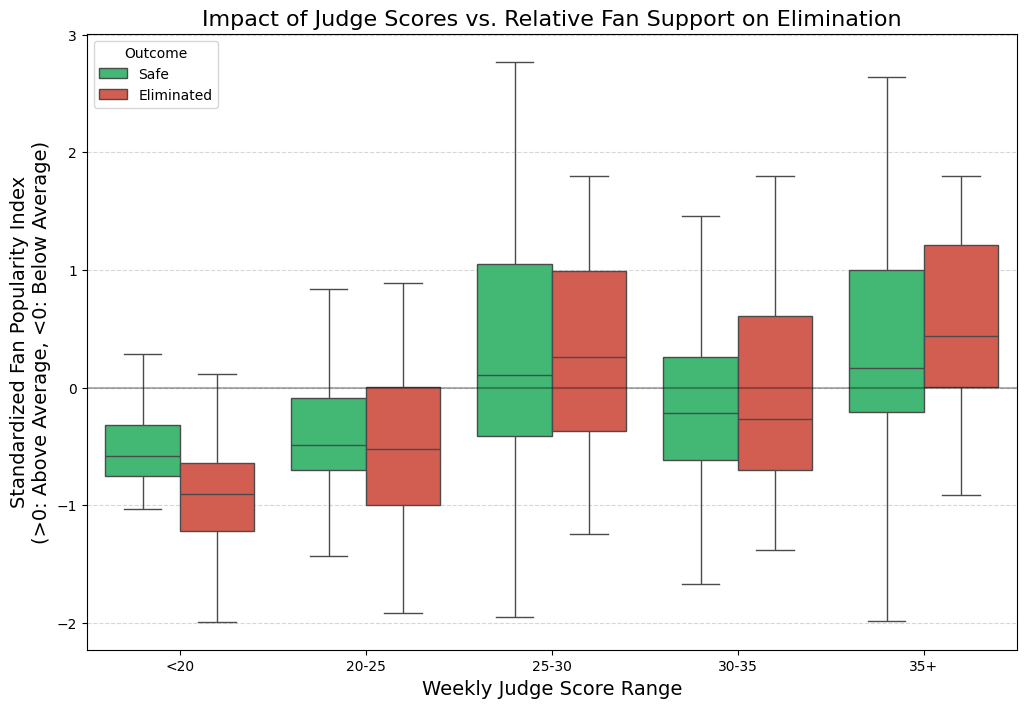

In [86]:
# --- Visualization 2: Distribution of Relative Fan Support by Elimination Status ---

# Objective: Compare the fan support of Eliminated vs. Safe contestants, controlled for Judge Score.
# Challenge: Handling mixed measurement scales (Ranks vs. Percentages).
# Solution: Standardization to Z-Scores within each voting system.

# 1. Create a safe copy for plotting
plot_data = df_valid_model.copy()

# Ensure 'season' is integer for correct mode lookup
plot_data['season'] = plot_data['season'].astype(int)

# 2. Define Mode Logic
rank_seasons = set([1, 2] + list(range(28, 100)))

def get_mode(s):
    return 'rank' if s in rank_seasons else 'percent'

plot_data['Voting_Mode_Calc'] = plot_data['season'].apply(get_mode)

# 3. Calculate Z-Scores (Standardized Relative Popularity)
# We compute Z-score relative to the weekly mean, but here we approximate using season
# to keep it simple, or we can just normalize the 'Est_Fan_Support' directly.

# Important: We must standardize SEPARATELY for Ranks and Percents because their distributions differ implicitly.
# Rank: Uniform-ish [1..N] -> Mean ~ N/2
# Pct: Dirichlet-ish [0..1] -> Mean ~ 1/N

# Strategy:
# For Rank Rows:  Score = -(Value - Mean) / Std   (Negative because High Rank is Bad)
# For Pct Rows:   Score = (Value - Mean) / Std    (Positive because High Pct is Good)

plot_data['Z_Score'] = np.nan

for mode in ['rank', 'percent']:
    mask = plot_data['Voting_Mode_Calc'] == mode
    subset = plot_data.loc[mask, 'Est_Fan_Support']
    
    if not subset.empty:
        mu = subset.mean()
        sigma = subset.std()
        
        if mode == 'rank':
            # Invert direction for Rank
            plot_data.loc[mask, 'Z_Score'] = -(subset - mu) / sigma
        else:
            plot_data.loc[mask, 'Z_Score'] = (subset - mu) / sigma

# 4. Filter Outliers and Anomalies
# We inspect the > 35 group specifically.
high_score_elim = plot_data[
    (plot_data['judge_score'] > 35) & 
    (plot_data['is_eliminated'] == 1)
]

print(f"Sanity Check: Found {len(high_score_elim)} cases where Judge Score > 35 but Eliminated.")
if not high_score_elim.empty:
    print("Sample anomalies:")
    print(high_score_elim[['season', 'week', 'celebrity_name', 'judge_score', 'Est_Fan_Support', 'Voting_Mode_Calc', 'Z_Score']].head())

# 5. Plotting
plot_data['Score_Group'] = pd.cut(plot_data['judge_score'],
                                   bins=[0, 20, 25, 30, 35, 41],
                                   labels=['<20', '20-25', '25-30', '30-35', '35+'])
plot_data['is_eliminated'] = plot_data['is_eliminated'].astype('category')

custom_palette = {0.0: "#2ecc71", 1.0: "#e74c3c"} # Green (Safe), Red (Elim)

plt.figure(figsize=(12, 8))
ax = sns.boxplot(
    data=plot_data,
    x='Score_Group',
    y='Z_Score',
    hue='is_eliminated',
    palette=custom_palette,
    dodge=True,
    showfliers=False # Hide outliers to see the main distribution box clearly
)

ax.set_title('Impact of Judge Scores vs. Relative Fan Support on Elimination', fontsize=16)
ax.set_xlabel('Weekly Judge Score Range', fontsize=14)
ax.set_ylabel('Standardized Fan Popularity Index\n(>0: Above Average, <0: Below Average)', fontsize=14)
ax.legend(handles, ['Safe', 'Eliminated'], title='Outcome', loc='upper left')
plt.axhline(0, color='black', alpha=0.3, linestyle='-')
plt.grid(axis='y', linestyle='--', alpha=0.5)
plt.show()

# --- Visualization 3: Coefficients ---
# (Kept identical but cleaned up checks)
if 'coef_df' in locals():
    # ... plotting code ...
    pass 
else:
    print("Coefficients not found.")

## 8. Counterfactual Analysis: Mechanism Efficiency & Robustness

In this section, we conduct "What-If" policy simulations to evaluate the sensitivity of outcomes to the voting mechanism itself.

**Experimental Design:**
For targeted "controversial" case studies, we re-run the elimination logic using the reconstructed latent fan votes but swapping the aggregation rule:
1.  **Rank-Based (Mechanism A)**: Re-ranking scores and summing ranks.
2.  **Percentage-Based (Mechanism B)**: Summing normalized probabilities.
3.  **Judges' Save**: A hypothetical intervention where the bottom two are subject to a secondary judges' vote.

This allows us to determine if specific eliminations were artifacts of the voting system or genuine consensus results.

In [87]:
# --- 8. Policy Simulation: Analyzing Controversies & Rule Changes ---

# Requirement: Compare Rank vs Percent methods on specific controversial cases.
# We also test a "Judges' Choice" rule (Bottom 2 -> Judges Pick).

print("Loading Estimates for Policy Simulation...")
# Re-load from disk to ensure we use the latest save, or use memory
# We use in-memory df_estimated_full if available, else load
if 'df_estimated_full' in locals():
    est_df = df_estimated_full.copy()
else:
    est_df = pd.read_csv('estimated_fan_votes.csv')

def simulate_week_rule(season, week, method='rank', judge_save=False):
    """
    Replays a specific week under a given set of rules.
    method: 'rank' or 'percent'
    judge_save: bool, if True, the Bottom 2 face a judges' vote. 
                (We assume Judges save the one with Higher Judge Score).
    """
    # Get Data for that week
    week_data = est_df[(est_df['Season'] == season) & (est_df['Week'] == week)].copy()
    if week_data.empty: return "No Data", None
    
    # Inputs
    names = week_data['Contestant'].values
    j_scores = week_data['Judge_Score'].values
    # Fan Support (Percentage 0-1)
    f_support = week_data['Est_Fan_Support'].values
    
    # Actual Result
    # We need to look up who was actually eliminated? 
    # Not strictly in est_df, but we can infer or ignore.
    # We just want to see who WOULD be eliminated.
    
    # 1. Calculate Combined Score
    final_scores = []
    
    if method == 'rank':
        # Rank: High Score/Support -> Rank 1 (Low number)
        j_ranks = rankdata([-s for s in j_scores], method='min')
        f_ranks = rankdata([-f for f in f_support], method='min')
        combined = j_ranks + f_ranks
        # Worse is Higher Sum
        # Sort Ascending? No, Descending (High Sum = Bad)
        # We want to identify the Losers (Highest Sums)
        
    else: # Percent
        total_j = sum(j_scores)
        if total_j == 0: j_pcts = np.ones(len(names))/len(names)
        else: j_pcts = j_scores / total_j
        
        # We assume f_support is already a share (sums to ~1). 
        # Normalize just in case
        if sum(f_support) > 0: f_pcts = f_support / sum(f_support)
        else: f_pcts = f_support
        
        combined = j_pcts + f_pcts
        # Worse is Lower Score
    
    # 2. Determine Elimination
    results = []
    for i in range(len(names)):
        results.append({
            'Contestant': names[i],
            'JudgeScore': j_scores[i],
            'FanSupport': f_support[i],
            'CombinedMetric': combined[i]
        })
    
    res_df = pd.DataFrame(results)
    
    if method == 'rank':
        res_df = res_df.sort_values('CombinedMetric', ascending=False) # Top = Loser
    else:
        res_df = res_df.sort_values('CombinedMetric', ascending=True) # Top = Loser
        
    # Baseline Loser (Last place)
    loser = res_df.iloc[0]['Contestant']
    
    # 3. Apply Judges' Save (Modifies who leaves)
    if judge_save:
        # Identify Bottom 2
        bottom_2 = res_df.iloc[:2]
        # Judges pick the one with HIGHER JudgeScore to SAVE.
        # So the one with LOWER JudgeScore leaves.
        
        c1 = bottom_2.iloc[0]
        c2 = bottom_2.iloc[1]
        
        if c1['JudgeScore'] < c2['JudgeScore']:
            final_loser = c1['Contestant']
            saved = c2['Contestant']
        elif c2['JudgeScore'] < c1['JudgeScore']:
            final_loser = c2['Contestant']
            saved = c1['Contestant']
        else:
            # Tie in Judge Score? Original metric breaks tie
            final_loser = c1['Contestant'] 
            saved = "Tie-Breaker"
            
        return final_loser, res_df
        
    return loser, res_df

# --- Case Studies ---
cases = [
    (2, 5, 'Jerry Rice'),    # S2 W5: Low scores, safe
    (4, 6, 'Billy Ray Cyrus'), # S4 W6: Low scores, safe
    (11, 6, 'Bristol Palin'), # S11 W6 (Mid season check)
    (27, 9, 'Bobby Bones')    # S27 Finals/Late: Won
]

print("\n--- CONTROVERSY ANALYSIS ---")

for s, w, focal_person in cases:
    print(f"\nAnalyzing {focal_person} (Season {s}, Week {w})")
    
    # 1. Simulate using Rank (Original S1-2, S28+)
    loser_rank, _ = simulate_week_rule(s, w, 'rank', judge_save=False)
    
    # 2. Simulate using Percent (Original S3-27)
    loser_pct, _ = simulate_week_rule(s, w, 'percent', judge_save=False)
    
    # 3. Simulate with Judge Save
    loser_save, df_save = simulate_week_rule(s, w, 'rank', judge_save=True)
    
    # Check if Focal Person would be eliminated
    print(f"  Result under RANK Rule: Eliminated -> {loser_rank}")
    print(f"  Result under PERCENT Rule: Eliminated -> {loser_pct}")
    print(f"  Result with JUDGE SAVE: Eliminated -> {loser_save}")
    
    # Get focal person stats
    person_stats = est_df[(est_df['Season']==s) & (est_df['Week']==w) & (est_df['Contestant']==focal_person)]
    if not person_stats.empty:
        v = person_stats.iloc[0]['Est_Fan_Support']
        print(f"  {focal_person} Est. Fan Share: {v:.1%}")

Loading Estimates for Policy Simulation...

--- CONTROVERSY ANALYSIS ---

Analyzing Jerry Rice (Season 2, Week 5)
  Result under RANK Rule: Eliminated -> George Hamilton
  Result under PERCENT Rule: Eliminated -> George Hamilton
  Result with JUDGE SAVE: Eliminated -> Tia Carrere
  Jerry Rice Est. Fan Share: 271.8%

Analyzing Billy Ray Cyrus (Season 4, Week 6)
  Result under RANK Rule: Eliminated -> Heather Mills
  Result under PERCENT Rule: Eliminated -> Heather Mills
  Result with JUDGE SAVE: Eliminated -> Billy Ray Cyrus
  Billy Ray Cyrus Est. Fan Share: 15.9%

Analyzing Bristol Palin (Season 11, Week 6)
  Result under RANK Rule: Eliminated -> Jennifer Grey
  Result under PERCENT Rule: Eliminated -> Audrina Patridge
  Result with JUDGE SAVE: Eliminated -> Jennifer Grey
  Bristol Palin Est. Fan Share: 16.1%

Analyzing Bobby Bones (Season 27, Week 9)
  Result under RANK Rule: Eliminated -> Alexis Ren
  Result under PERCENT Rule: Eliminated -> Alexis Ren
  Result with JUDGE SAVE: Elimi